In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [6]:
positive_dir = Path('/Users/harshavardhanreddymalikireddy/Desktop/dataset/Positive')
negative_dir = Path('/Users/harshavardhanreddymalikireddy/Desktop/dataset/Negative')


In [8]:
from pathlib import Path
import pandas as pd

positive_dir = Path('/Users/harshavardhanreddymalikireddy/Desktop/dataset/Positive')
negative_dir = Path('/Users/harshavardhanreddymalikireddy/Desktop/dataset/Negative')

def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob('*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print(all_df.head())
print(all_df.shape)


                                            Filepath     Label
0  /Users/harshavardhanreddymalikireddy/Desktop/d...  POSITIVE
1  /Users/harshavardhanreddymalikireddy/Desktop/d...  POSITIVE
2  /Users/harshavardhanreddymalikireddy/Desktop/d...  POSITIVE
3  /Users/harshavardhanreddymalikireddy/Desktop/d...  NEGATIVE
4  /Users/harshavardhanreddymalikireddy/Desktop/d...  POSITIVE
(40000, 2)


In [9]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [10]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/Users/harshavardhanreddymalikireddy/Desktop/d...,POSITIVE
1,/Users/harshavardhanreddymalikireddy/Desktop/d...,POSITIVE
2,/Users/harshavardhanreddymalikireddy/Desktop/d...,POSITIVE
3,/Users/harshavardhanreddymalikireddy/Desktop/d...,NEGATIVE
4,/Users/harshavardhanreddymalikireddy/Desktop/d...,POSITIVE
...,...,...
39995,/Users/harshavardhanreddymalikireddy/Desktop/d...,POSITIVE
39996,/Users/harshavardhanreddymalikireddy/Desktop/d...,NEGATIVE
39997,/Users/harshavardhanreddymalikireddy/Desktop/d...,POSITIVE
39998,/Users/harshavardhanreddymalikireddy/Desktop/d...,POSITIVE


In [11]:
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [12]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [13]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [14]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [15]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


2025-11-24 21:23:19.392249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-11-24 21:23:19.447043: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


104/105 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5547

2025-11-24 21:23:24.916719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


105/105 [==============================] - 6s 56ms/step - loss: 0.6858 - accuracy: 0.5545 - val_loss: 0.6682 - val_accuracy: 0.7679
Epoch 2/100
105/105 [==============================] - 7s 64ms/step - loss: 0.6516 - accuracy: 0.6378 - val_loss: 0.6001 - val_accuracy: 0.7774
Epoch 3/100
105/105 [==============================] - 6s 53ms/step - loss: 0.5510 - accuracy: 0.7726 - val_loss: 0.4893 - val_accuracy: 0.8500
Epoch 4/100
105/105 [==============================] - 6s 54ms/step - loss: 0.4534 - accuracy: 0.8693 - val_loss: 0.3805 - val_accuracy: 0.8964
Epoch 5/100
105/105 [==============================] - 6s 54ms/step - loss: 0.3422 - accuracy: 0.9122 - val_loss: 0.2902 - val_accuracy: 0.9381
Epoch 6/100
105/105 [==============================] - 6s 58ms/step - loss: 0.2655 - accuracy: 0.9339 - val_loss: 0.2351 - val_accuracy: 0.9226
Epoch 7/100
105/105 [==============================] - 6s 60ms/step - loss: 0.2206 - accuracy: 0.9402 - val_loss: 0.2157 - val_accuracy: 0.9345
Epoc

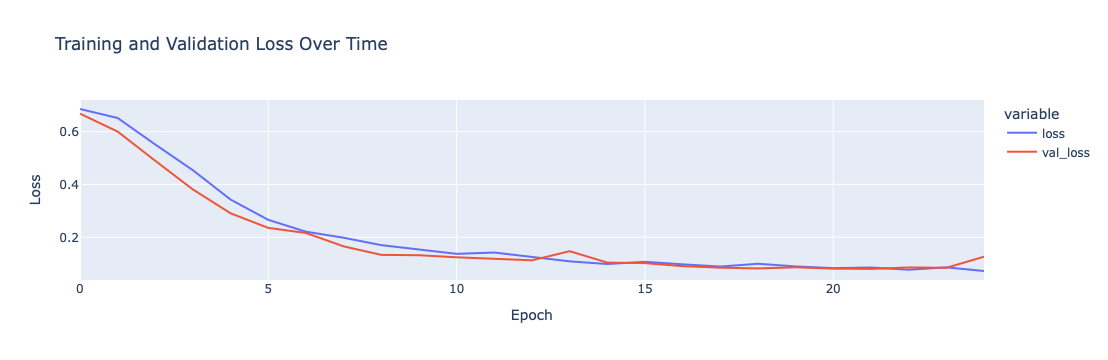

In [16]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

In [17]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

2025-11-24 21:26:47.772681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


    Test Loss: 0.09563
Test Accuracy: 97.56%
 4/57 [=>............................] - ETA: 1s

2025-11-24 21:26:49.340816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 1s 20ms/step


/var/folders/hr/qy7pb4cj5w10b4xpq6t9jx3h0000gn/T/ipykernel_68348/3772050799.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



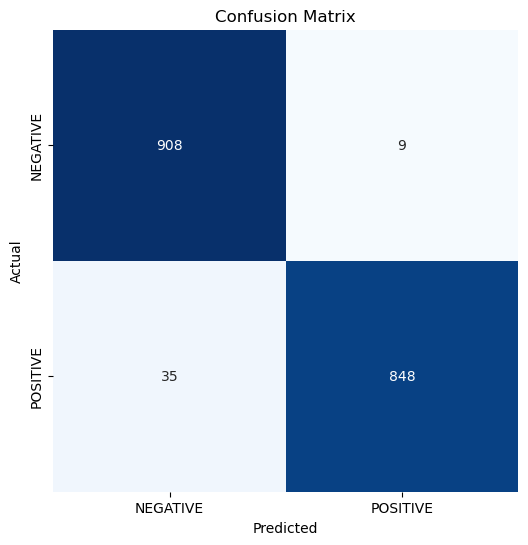

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.99      0.98       917
    POSITIVE       0.99      0.96      0.97       883

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [18]:
evaluate_model(model, test_data)